In [1]:
import matplotlib.pyplot as plt
from time import time
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torchsummary import summary
import pandas as pd 
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.nn.modules.loss import CrossEntropyLoss
from IPython.core.debugger import set_trace
from pathlib import Path
from tqdm.auto import tqdm
from funhelper import get_df_all, download
from train_helper import get_dataloader, fit, validate 
import causal_convolution_layer
import Dataloader
from tqdm import tqdm

/home/qing/.conda/envs/PyTorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data Import 

In [3]:
working_dir = Path('/home/qing/Project/Code/CWRU-1')
DATA_PATH = Path("./Data")
save_model_path = working_dir / 'Model'
DE_path = DATA_PATH / '12k_DE'

In [4]:
# load data
df_all = get_df_all(DE_path, segment_length=500, normalize=True)
features = df_all.columns[2:]
target = 'label'
df_all.sample(5)

,label,filename,0,1,2,3,4,5,6,7,...,490,491,492,493,494,495,496,497,498,499
215,2,Data/12k_DE/IR028_2.mat,2.818930,1.243664,-1.143175,0.223151,2.062976,0.604272,-0.200531,0.458208,...,-2.472260,-1.604583,-0.325798,0.074669,-0.395444,-0.012873,1.171116,1.176920,0.242497,0.310209
1216,1,Data/12k_DE/B007_1.mat,-0.480198,1.050512,1.167361,-0.921884,-1.132211,0.906789,0.682441,-1.004847,...,-0.227806,-0.087589,0.468609,0.609995,0.303853,0.162466,0.323717,0.095863,0.453418,0.717495
12190,3,Data/12k_DE/OR014@6_0.mat,-0.191117,-1.224750,-0.047296,0.349942,-2.255125,1.692403,1.579954,-1.595913,...,1.220199,-0.274231,0.256642,0.711327,0.332423,-1.404424,-0.052185,1.907115,-0.439238,-0.146300
747,2,Data/12k_DE/IR028_0.mat,0.713018,0.190779,-1.828771,-1.312842,1.339122,2.181694,0.482476,0.014111,...,0.218444,0.439765,0.203398,0.300954,0.409673,-0.032968,0.398995,1.227006,0.688751,-0.219829
2536,1,Data/12k_DE/B007_2.mat,-0.267189,-0.867570,-0.110472,1.356267,0.476665,-0.851016,0.438037,1.229348,...,-0.636909,-0.294780,1.571477,1.167544,-1.482299,-1.281436,1.436833,0.978822,-0.966898,-0.216422


In [5]:
df_all['label'].unique()

array([2, 1, 3, 0])

In [6]:
train=df_all.sample(frac=0.8,random_state=200) #random state is a seed value
test=df_all.drop(train.index)
x_test= test[features]
y_test= test[target]

In [7]:
random_seed = 200
x_train, x_valid, y_train, y_valid = train_test_split(train[features], 
                                                      train[target], 
                                                      test_size=0.20, random_state=random_seed, shuffle=True
                                                     )

### Hyperparameters

In [8]:
bs = 64
# lr = 0.001
wd = 1e-5
betas=(0.99, 0.999)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
random_seed = 200

### Create DataLoader of train and validation set (dataframe to tensor)

In [9]:
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
x_valid_tensor = torch.tensor(x_valid.values, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
# train_ds = TensorDataset(x_train_tensor, y_train_tensor)
# valid_ds = TensorDataset(x_valid_tensor, y_valid_tensor)
# test_ds = TensorDataset(x_test_tensor, y_test_tensor)
# train_dl, valid_dl, test_dl = get_dataloader(train_ds, valid_ds,test_ds, bs)

In [10]:
#x_train_tensor.shape
x_train_tensor.to(device)
x_valid_tensor.to(device)
x_test_tensor.to(device)
y_train_tensor.to(device)
y_valid_tensor.to(device)
y_test_tensor.to(device)

tensor([2, 2, 2,  ..., 0, 0, 0], device='cuda:0')

In [11]:
train_dataset = Dataloader.time_series_decoder_paper(x_train_tensor,y_train_tensor)
valid_dataset = Dataloader.time_series_decoder_paper(x_valid_tensor,y_valid_tensor)
test_dataset = Dataloader.time_series_decoder_paper(x_test_tensor,y_test_tensor)

x: 11512*500 fx: 11512
x: 2878*500 fx: 2878
x: 3597*500 fx: 3597


In [23]:
from torch.utils.data.dataloader import default_collate
train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True,collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
valid_dl = DataLoader(valid_dataset,batch_size=64,collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_dl = DataLoader(test_dataset,batch_size=128,collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [24]:
## Instantiate model, optimizer and loss function
torch.manual_seed(123)

## Transformer Time Series Model 

In [25]:
class TransformerTimeSeries(torch.nn.Module):
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(1,256,9)
        self.positional_embedding = torch.nn.Embedding(512,256)
        
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=256,nhead=8)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=3)
        
        self.fc1 = torch.nn.Linear(256,1)

        self.fc2 = torch.nn.Linear(500,4)

    def forward(self,x,attention_masks):
        
        # concatenate observed points and time covariate
        # (B*feature_size*n_time_points)
        #z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)
        z = x.unsqueeze(1)
        # input_embedding returns shape (Batch size,embedding size,sequence len) -> need (sequence len,Batch size,embedding_size)
        z_embedding = self.input_embedding(z).permute(2,0,1)
        
        # get my positional embeddings (Batch size, sequence_len, embedding_size) -> need (sequence len,Batch size,embedding_size)
        #positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)
        
        input_embedding = z_embedding #+positional_embeddings
        
        transformer_embedding = self.transformer_decoder(input_embedding, attention_masks)

        output1 = self.fc1(transformer_embedding.permute(1,0,2))
        
        output = self.fc2(output1[:,:,0])  

        #F.log_softmax(output,dim = 1) 
        #F.softmax(output,dim = 1) 
        #return F.softmax(output,dim = 1) #output
        return output


In [26]:
model = TransformerTimeSeries()
model.to(device)

TransformerTimeSeries(
  (input_embedding): context_embedding(
    (causal_convolution): CausalConv1d(1, 256, kernel_size=(9,), stride=(1,))
  )
  (positional_embedding): Embedding(512, 256)
  (decode_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_decoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=

### Hyperparameters

In [27]:
criterion = torch.nn.CrossEntropyLoss()
#lr = .005 # learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 50

In [28]:
def Dp(y_pred,y_true,q):
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])

In [29]:
def Rp_num_den(y_preds,y_trues,q):
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator

In [30]:
def train_epoch(model,train_dl):
    model.train()
    train_loss = 0
    train_numright = 0
    n = 0
    for step,(x,y,attention_masks) in enumerate(tqdm(train_dl)):
        optimizer.zero_grad()
        output = model(x,attention_masks[0])
        loss = criterion(output,y)
        #loss = criterion(output.squeeze()[:,(t0-1):(t0+24-1)],y[:,t0:]) # not missing data
        # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y[:,(t0-10):]) # missing data
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(output.data, 1)

        train_loss += (loss.detach().cpu().item() * x.shape[0])
        train_numright += (predicted == y).sum().item()
        n += x.shape[0]
    return train_loss/n, train_numright/n

In [31]:
def eval_epoch(model,valid_dl):
    model.eval()
    eval_loss = 0
    eval_numright = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,attention_masks) in enumerate(tqdm(valid_dl)):
            output = model(x,attention_masks[0])
            loss = criterion(output,y)

            _, predicted = torch.max(output.data, 1)
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            eval_numright += (predicted == y).sum().item()
            n += x.shape[0]
            
    return eval_loss/n, eval_numright/n

In [32]:
def test_epoch(model,test_dl):
    model.eval()
    eval_loss = 0
    eval_numright = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,attention_masks) in enumerate(tqdm(test_dl)):
            output = model(x,attention_masks[0])
            loss = criterion(output,y)

            _, predicted = torch.max(output.data, 1)
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            eval_numright += (predicted == y).sum().item()
            n += x.shape[0]
            
    return eval_loss/n, eval_numright/n

In [33]:
train_epoch_loss = []
eval_epoch_loss = []
train_epoch_acc = []
eval_epoch_acc = []
Rp_best = 10
for e in range(epochs):
    train_loss = []
    eval_loss = []
    train_acc = []
    eval_acc = []

    l_t, a_t = train_epoch(model,train_dl)
    train_loss.append(l_t)
    train_acc.append(a_t)

    l_e, a_e = eval_epoch(model,valid_dl)
    eval_loss.append(l_e)
    eval_acc.append(a_e)
    
        
    train_epoch_loss.append(np.mean(train_loss))
    eval_epoch_loss.append(np.mean(eval_loss))
    train_epoch_acc.append(np.mean(train_acc))
    eval_epoch_acc.append(np.mean(eval_acc))

    print("Epoch {}: Train loss/accuracy: {} / {} \t Validation loss/accuracy: {} / {}".format(e,
                                                             np.mean(train_loss),
                                                             np.mean(train_acc),
                                                             np.mean(eval_loss),
                                                             np.mean(eval_acc)))

  0%|          | 0/360 [00:00<?, ?it/s]/home/qing/.conda/envs/PyTorch/lib/python3.10/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 45/45 [00:01<00:00, 23.09it/s]


Epoch 0: Train loss/accuracy: 0.9060841840617436 / 0.547776233495483 	 Validation loss/accuracy: 0.8054635579011107 / 0.6125781792911744


100%|██████████| 45/45 [00:01<00:00, 23.17it/s]


Epoch 1: Train loss/accuracy: 0.7883792707205979 / 0.6188325225851286 	 Validation loss/accuracy: 0.7182666305206649 / 0.6594857539958304


100%|██████████| 45/45 [00:01<00:00, 22.96it/s]


Epoch 2: Train loss/accuracy: 0.6145840676979027 / 0.7231584433634468 	 Validation loss/accuracy: 0.7230437037595201 / 0.6712995135510771


100%|██████████| 45/45 [00:01<00:00, 23.13it/s]


Epoch 3: Train loss/accuracy: 0.5013235384097441 / 0.7749305072967339 	 Validation loss/accuracy: 0.4155558662914915 / 0.8047255038220987


100%|██████████| 45/45 [00:01<00:00, 23.10it/s]


Epoch 4: Train loss/accuracy: 0.4217651196864846 / 0.8139332870048644 	 Validation loss/accuracy: 0.3612834733960693 / 0.8373870743571925


100%|██████████| 45/45 [00:01<00:00, 23.02it/s]


Epoch 5: Train loss/accuracy: 0.3319250644754833 / 0.8547602501737318 	 Validation loss/accuracy: 0.36690324130697827 / 0.8353022932592078


100%|██████████| 45/45 [00:01<00:00, 22.99it/s]


Epoch 6: Train loss/accuracy: 0.2441524353636852 / 0.9066191799861014 	 Validation loss/accuracy: 0.15725669238905346 / 0.9343293954134816


100%|██████████| 45/45 [00:01<00:00, 22.85it/s]


Epoch 7: Train loss/accuracy: 0.12750238317237744 / 0.9536136205698401 	 Validation loss/accuracy: 0.19097693811240007 / 0.935371785962474


100%|██████████| 45/45 [00:01<00:00, 22.90it/s]


Epoch 8: Train loss/accuracy: 0.09301403420508074 / 0.967685892981237 	 Validation loss/accuracy: 0.08803996820160712 / 0.9718554551772064


100%|██████████| 45/45 [00:01<00:00, 22.98it/s]


Epoch 9: Train loss/accuracy: 0.0653583872552037 / 0.9782835302293259 	 Validation loss/accuracy: 0.056508817781821735 / 0.9815844336344683


100%|██████████| 45/45 [00:01<00:00, 22.91it/s]


Epoch 10: Train loss/accuracy: 0.048706113456931585 / 0.9841035441278666 	 Validation loss/accuracy: 0.39510326169281057 / 0.8929812369701181


100%|██████████| 45/45 [00:01<00:00, 22.87it/s]


Epoch 11: Train loss/accuracy: 0.056576700184896814 / 0.9819318971507992 	 Validation loss/accuracy: 0.06718405902054345 / 0.9788047255038221


100%|██████████| 45/45 [00:01<00:00, 22.84it/s]


Epoch 12: Train loss/accuracy: 0.029657043155821208 / 0.9906184850590688 	 Validation loss/accuracy: 0.03823799103410439 / 0.9885337039610841


100%|██████████| 45/45 [00:01<00:00, 22.82it/s]


Epoch 13: Train loss/accuracy: 0.028258894126515388 / 0.9900972897845726 	 Validation loss/accuracy: 0.098980146710702 / 0.9715079916608756


100%|██████████| 45/45 [00:01<00:00, 22.91it/s]


Epoch 14: Train loss/accuracy: 0.013904234341755 / 0.9959173036831133 	 Validation loss/accuracy: 0.05197610380354546 / 0.9874913134120917


100%|██████████| 45/45 [00:01<00:00, 22.87it/s]


Epoch 15: Train loss/accuracy: 0.0069572605276433394 / 0.9978283530229326 	 Validation loss/accuracy: 0.029024196914225673 / 0.9906184850590688


100%|██████████| 45/45 [00:01<00:00, 22.92it/s]


Epoch 16: Train loss/accuracy: 0.007803372290523243 / 0.9974808895066019 	 Validation loss/accuracy: 0.025849242648401036 / 0.9927032661570535


100%|██████████| 45/45 [00:01<00:00, 22.83it/s]


Epoch 17: Train loss/accuracy: 0.004422125376788233 / 0.9984364141765114 	 Validation loss/accuracy: 0.02803342889371775 / 0.9916608756080612


100%|██████████| 45/45 [00:01<00:00, 23.01it/s]


Epoch 18: Train loss/accuracy: 0.0015416319014910993 / 0.9994788047255038 	 Validation loss/accuracy: 0.03348400233322502 / 0.9927032661570535


100%|██████████| 45/45 [00:01<00:00, 22.92it/s]


Epoch 19: Train loss/accuracy: 0.006206087756582444 / 0.9977414871438499 	 Validation loss/accuracy: 0.032773594621713246 / 0.9933981931897151


100%|██████████| 45/45 [00:01<00:00, 22.90it/s]


Epoch 20: Train loss/accuracy: 0.013249713663173731 / 0.9966990965948576 	 Validation loss/accuracy: 0.03468942731622764 / 0.990271021542738


100%|██████████| 45/45 [00:01<00:00, 22.74it/s]


Epoch 21: Train loss/accuracy: 0.0013797405648311484 / 0.9997394023627519 	 Validation loss/accuracy: 0.064197514604038 / 0.9857539958304378


100%|██████████| 45/45 [00:01<00:00, 22.89it/s]


Epoch 22: Train loss/accuracy: 0.001400564527356765 / 0.9994788047255038 	 Validation loss/accuracy: 0.029679245013491878 / 0.9930507296733843


100%|██████████| 45/45 [00:01<00:00, 22.91it/s]


Epoch 23: Train loss/accuracy: 0.0011779969200831195 / 0.9998262682418346 	 Validation loss/accuracy: 0.04042454036984973 / 0.9923558026407228


100%|██████████| 45/45 [00:01<00:00, 22.93it/s]


Epoch 24: Train loss/accuracy: 0.0006335680419113467 / 1.0 	 Validation loss/accuracy: 0.028942060676302058 / 0.9930507296733843


100%|██████████| 45/45 [00:01<00:00, 22.90it/s]


Epoch 25: Train loss/accuracy: 0.00026607159590495537 / 1.0 	 Validation loss/accuracy: 0.027977815581905662 / 0.9940931202223766


100%|██████████| 45/45 [00:01<00:00, 22.82it/s]


Epoch 26: Train loss/accuracy: 0.01265852572696929 / 0.9970465601111883 	 Validation loss/accuracy: 0.03882201861101025 / 0.9933981931897151


100%|██████████| 45/45 [00:01<00:00, 22.88it/s]


Epoch 27: Train loss/accuracy: 0.0005203491146378429 / 1.0 	 Validation loss/accuracy: 0.028583710834246757 / 0.9940931202223766


100%|██████████| 45/45 [00:01<00:00, 22.86it/s]


Epoch 28: Train loss/accuracy: 0.0003404416266449081 / 1.0 	 Validation loss/accuracy: 0.03371810197665649 / 0.9930507296733843


100%|██████████| 45/45 [00:01<00:00, 22.89it/s]


Epoch 29: Train loss/accuracy: 0.00029492301070842573 / 1.0 	 Validation loss/accuracy: 0.02927384968061334 / 0.9940931202223766


100%|██████████| 45/45 [00:01<00:00, 22.90it/s]


Epoch 30: Train loss/accuracy: 0.0001438199577053962 / 1.0 	 Validation loss/accuracy: 0.030706214787083522 / 0.9937456567060459


100%|██████████| 45/45 [00:01<00:00, 22.81it/s]


Epoch 31: Train loss/accuracy: 0.0001178960410868789 / 1.0 	 Validation loss/accuracy: 0.030212952338310853 / 0.9937456567060459


100%|██████████| 45/45 [00:01<00:00, 23.00it/s]


Epoch 32: Train loss/accuracy: 0.00017168241483659426 / 1.0 	 Validation loss/accuracy: 0.029485167353252198 / 0.9944405837387075


100%|██████████| 45/45 [00:01<00:00, 22.89it/s]


Epoch 33: Train loss/accuracy: 0.00010291046935320242 / 1.0 	 Validation loss/accuracy: 0.030225706299692633 / 0.9937456567060459


100%|██████████| 45/45 [00:01<00:00, 22.83it/s]


Epoch 34: Train loss/accuracy: 0.00013728844371249627 / 1.0 	 Validation loss/accuracy: 0.03074867173840772 / 0.9933981931897151


100%|██████████| 45/45 [00:01<00:00, 22.88it/s]


Epoch 35: Train loss/accuracy: 0.0001076910329561495 / 1.0 	 Validation loss/accuracy: 0.03037517799517639 / 0.9940931202223766


100%|██████████| 45/45 [00:01<00:00, 23.04it/s]


Epoch 36: Train loss/accuracy: 0.00010134685080322888 / 1.0 	 Validation loss/accuracy: 0.03177623354124884 / 0.9937456567060459


100%|██████████| 45/45 [00:01<00:00, 22.74it/s]


Epoch 37: Train loss/accuracy: 7.417716343639332e-05 / 1.0 	 Validation loss/accuracy: 0.03146754987054078 / 0.9940931202223766


100%|██████████| 45/45 [00:01<00:00, 22.86it/s]


Epoch 38: Train loss/accuracy: 7.628108610216657e-05 / 1.0 	 Validation loss/accuracy: 0.03213364021183002 / 0.9940931202223766


100%|██████████| 45/45 [00:01<00:00, 22.88it/s]


Epoch 39: Train loss/accuracy: 7.652545284069003e-05 / 1.0 	 Validation loss/accuracy: 0.03328895610064262 / 0.9933981931897151


100%|██████████| 45/45 [00:01<00:00, 22.81it/s]


Epoch 40: Train loss/accuracy: 7.608694918550041e-05 / 1.0 	 Validation loss/accuracy: 0.03097962111155302 / 0.9944405837387075


100%|██████████| 45/45 [00:01<00:00, 22.92it/s]


Epoch 41: Train loss/accuracy: 6.977618101254601e-05 / 1.0 	 Validation loss/accuracy: 0.028209089884118892 / 0.995135510771369


100%|██████████| 45/45 [00:01<00:00, 22.94it/s]


Epoch 42: Train loss/accuracy: 6.537493344154437e-05 / 1.0 	 Validation loss/accuracy: 0.028833042023371117 / 0.9947880472550382


100%|██████████| 45/45 [00:01<00:00, 22.83it/s]


Epoch 43: Train loss/accuracy: 6.233460560391888e-05 / 1.0 	 Validation loss/accuracy: 0.030987890517538773 / 0.9944405837387075


100%|██████████| 45/45 [00:01<00:00, 22.95it/s]


Epoch 44: Train loss/accuracy: 5.139636984919881e-05 / 1.0 	 Validation loss/accuracy: 0.031646906938670005 / 0.9944405837387075


100%|██████████| 45/45 [00:01<00:00, 22.99it/s]


Epoch 45: Train loss/accuracy: 5.3720958105488136e-05 / 1.0 	 Validation loss/accuracy: 0.0311897210242966 / 0.9947880472550382


100%|██████████| 45/45 [00:01<00:00, 22.91it/s]


Epoch 46: Train loss/accuracy: 4.551264835162195e-05 / 1.0 	 Validation loss/accuracy: 0.03427172325885789 / 0.9940931202223766


100%|██████████| 45/45 [00:01<00:00, 22.88it/s]


Epoch 47: Train loss/accuracy: 4.843244184906795e-05 / 1.0 	 Validation loss/accuracy: 0.03159634054727759 / 0.9947880472550382


100%|██████████| 45/45 [00:01<00:00, 22.93it/s]


Epoch 48: Train loss/accuracy: 5.870381713987812e-05 / 1.0 	 Validation loss/accuracy: 0.032965196517551455 / 0.9940931202223766


100%|██████████| 45/45 [00:01<00:00, 22.93it/s]

Epoch 49: Train loss/accuracy: 3.8919125162274965e-05 / 1.0 	 Validation loss/accuracy: 0.032198630866057114 / 0.9940931202223766


In [34]:
eval_epoch(model,test_dl)

100%|██████████| 29/29 [00:02<00:00, 11.42it/s]


(0.014015941604492758, 0.9966638865721434)

In [30]:
(x,y,attention_masks) = next(iter(test_dl))
# x.to(device)
# y.to(device)
# attention_masks.to(device)
out = model(x,attention_masks[0])

In [35]:
print(out[0,])
print(y[0])
print(x.shape)

tensor([-3.1910, -6.3077,  7.8491, -4.0130], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(2, device='cuda:0')
torch.Size([128, 500])


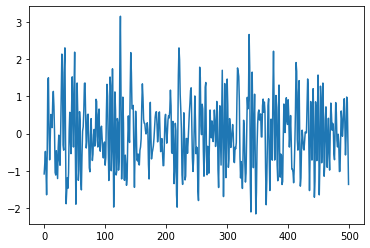

In [36]:
plt.plot(x[1,:].cpu().detach().numpy())

In [ ]:
# the class with the highest energy is what we choose as prediction
_, predicted = torch.max(out.data, 1)
print(predicted)
print(y)
print((predicted == y).sum().item())